# Text Mining TWITTER

In [0]:
#pip install seaborn


In [0]:
#pip install -U gensim


In [0]:
#pip install smart_open

In [3]:
import sys
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pprint import pprint
import tweepy
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaMulticore
from gensim.models import CoherenceModel
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1 .Collecte des données

In [0]:
CONSUMER_KEY    = 'wXu8ut21Atg9a4P7Zuci1ziA4'
CONSUMER_SECRET = 'qxVcWIeOVBaEPk2FBs5HPNpuUWlzADwZe2G8eR5JevoPDSkW0O'
ACCESS_TOKEN  = '1184566920416321539-rPmm3WWxpdwje5QVNdCjbOeo49ll7J'
ACCESS_SECRET = 'SX7baB6T5SxtOGsP9qeqhn7a1HGFim4NqA8apL7J2Gcc0'

In [0]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
api = tweepy.API(auth)

tweets_data = []
mcdo_tweets = api.user_timeline('McDoFr_Newsroom',count=200)
for tweet in mcdo_tweets:
    try:
        for reply in api.search(q="@McDoFr_Newsroom", since_id=tweet.id, count = 100):
            tweets_data.append(reply)
    except:  
        continue

In [8]:
len(mcdo_tweets)

200

In [9]:
len(tweets_data)

18000

In [0]:
def extract_tweet_attributes(tweet_object):
    tweet_list =[]
    for tweet in tweet_object:
        tweet_id = tweet.id
        text = tweet.text
        favorite_count = tweet.favorite_count
        retweet_count = tweet.retweet_count
        created_at = tweet.created_at
        source = tweet.source
        reply_to_status = tweet.in_reply_to_status_id
        reply_to_user = tweet.in_reply_to_screen_name
        retweets = tweet.retweet_count
        favorites = tweet.favorite_count
        # append attributes to list
        tweet_list.append({'tweet_id':tweet_id, 
                          'text':text, 
                          'favorite_count':favorite_count,
                          'retweet_count':retweet_count,
                          'created_at':created_at, 
                          'source':source, 
                          'reply_to_status':reply_to_status, 
                          'reply_to_user':reply_to_user,
                          'retweets':retweets,
                          'favorites':favorites})
    
    df = pd.DataFrame(tweet_list, columns=['tweet_id',
                                           'text',
                                           'favorite_count',
                                           'retweet_count',
                                           'created_at',
                                           'source',
                                           'reply_to_status',
                                           'reply_to_user',
                                           'retweets',
                                           'favorites'])
    return df


df = extract_tweet_attributes(tweets_data)

In [11]:
df.head()

,tweet_id,text,favorite_count,retweet_count,created_at,source,reply_to_status,reply_to_user,retweets,favorites
0,1250451727859539972,Les Noirs interdits d’accès dans les @McDoFr_N...,0,0,2020-04-15 15:51:38,Twitter Web App,NaN,None,0,0
1,1250450869532921856,@jbzvosmorts @McDoFr_Newsroom Mrc pour le troll,0,0,2020-04-15 15:48:14,Twitter Web App,1.250448e+18,jbzvosmorts,0,0
2,1250449816926248960,@dominos_pizzafr @McDoFr_Newsroom J’y travaill...,0,0,2020-04-15 15:44:03,Twitter for iPhone,1.250409e+18,dominos_pizzafr,0,0
3,1250448016361783296,@dt48plus C @McDoFr_Newsroom,1,0,2020-04-15 15:36:53,Twitter for iPhone,1.250447e+18,dt48plus,0,1
4,1250446487902998529,"Si t’enlève les faux culs, ceux qui te pourris...",0,0,2020-04-15 15:30:49,Twitter for iPhone,NaN,None,0,0


In [0]:
df.to_csv('tweets.csv', index = False, header=True)

## 2. Prétraitement des données

### 2.1 Tokenization

In [0]:
df = pd.read_csv("tweets.csv")
df["tokens"] = df["text"]

In [14]:
nltk.download('punkt')
SENT_DETECTOR = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
df["tokens"] = df["tokens"].apply(word_tokenize)

In [16]:
df.tokens

0        [Les, Noirs, interdits, d, ’, accès, dans, les...
1        [@, jbzvosmorts, @, McDoFr_Newsroom, Mrc, pour...
2        [@, dominos_pizzafr, @, McDoFr_Newsroom, J, ’,...
3                     [@, dt48plus, C, @, McDoFr_Newsroom]
4        [Si, t, ’, enlève, les, faux, culs, ,, ceux, q...
                               ...                        
17995    [@, lucynotlucie, @, McDoFr_Newsroom, Javvvvv,...
17996    [RT, @, lucynotlucie, :, 5ème, personne, qui, ...
17997                   [@, giuxliano, @, McDoFr_Newsroom]
17998    [5ème, personne, qui, me, demande, si, Mcdo, c...
17999    [@, McDoFr_Newsroom, étant, donné, la, situati...
Name: tokens, Length: 18000, dtype: object

In [17]:
all_training_words = [word for tokens in df["tokens"] for word in tokens]
len(all_training_words)

303300

### 2.2 Transformation des mots en minuscules et élimination de la ponctuation

In [0]:
df["tokens"] = df["tokens"].apply(lambda tokens : [word.lower() for word in tokens if word.isalpha()])

In [19]:
df.tokens

0        [les, noirs, interdits, d, accès, dans, les, m...
1                      [jbzvosmorts, mrc, pour, le, troll]
2        [j, y, travaille, vous, êtes, des, hypocrites,...
3                                                      [c]
4        [si, t, enlève, les, faux, culs, ceux, qui, te...
                               ...                        
17995    [lucynotlucie, javvvvv, ce, taff, est, fait, p...
17996    [rt, lucynotlucie, personne, qui, me, demande,...
17997                                          [giuxliano]
17998    [personne, qui, me, demande, si, mcdo, c, est,...
17999    [étant, donné, la, situation, les, drive, de, ...
Name: tokens, Length: 18000, dtype: object

### 2.3 élimination des Stopwords

In [22]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
stop_words = set(stopwords.words(['french','english']))
df["tokens"] = df["tokens"].apply(lambda tokens : [word for word in tokens if not word in stop_words])

In [34]:
df.tokens

0        [noir, interdit, acces, mcdonald, chin, avis, ...
1                                 [jbzvosmort, mrc, troll]
2         [travaill, hypocrit, magasin, trop, petit, http]
3                                                       []
4        [si, enlev, faux, cul, ceux, pourr, vi, sais, ...
                               ...                        
17995    [lucynotluc, javvvvv, taff, fait, esper, va, f...
17996    [rt, lucynotluc, person, demand, si, mcdo, fer...
17997                                          [giuxliano]
17998    [person, demand, si, mcdo, ferm, pa, mdr, honn...
17999    [situat, driv, nouveau, ouvert, pens, question...
Name: tokens, Length: 18000, dtype: object

### 2.4 Application du Lemmatisation et du Stemming

In [35]:
nltk.download ('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
wordnet = WordNetLemmatizer()
df["tokens"] = df["tokens"].apply(lambda tokens : [wordnet.lemmatize(word) for word in tokens])

In [0]:
snowball = SnowballStemmer(language="french")
df["tokens"] = df["tokens"].apply(lambda tokens : [snowball.stem(word) for word in tokens])

In [38]:
df.tokens

0        [noir, interd, acce, mcdonald, chin, avis, exp...
1                                 [jbzvosmort, mrc, troll]
2             [travaill, hypocr, magasin, trop, pet, http]
3                                                       []
4        [si, enlev, faux, cul, ceux, pourr, vi, sais, ...
                               ...                        
17995    [lucynotluc, javvvvv, taff, fait, esper, va, f...
17996    [rt, lucynotluc, person, demand, si, mcdo, fer...
17997                                          [giuxliano]
17998    [person, demand, si, mcdo, ferm, pa, mdr, honn...
17999    [situat, driv, nouveau, ouvert, pen, question,...
Name: tokens, Length: 18000, dtype: object

In [39]:
all_training_words = [word for tokens in df["tokens"] for word in tokens]
len(all_training_words)

115920

## 4. Enregistrer les changements

In [0]:
df.to_csv('tweets.csv', index = False, header=True)

## 5. BoW (Bag of Words)

In [0]:
processed_docs = df.tokens

In [42]:
dct = Dictionary(processed_docs)
dct.filter_extremes(no_below=15, keep_n=100000)
print(dct)

Dictionary(331 unique tokens: ['acce', 'anglais', 'avis', 'chin', 'expliqu']...)


## 6. bow_corpus

In [0]:
processed_docs = processed_docs.iloc[:-10]
# Les 10 dernières lignes sont réservées pour le test

In [44]:
bow_corpus = [dct.doc2bow(doc) for doc in processed_docs]
bow_corpus[0:3]

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1)],
 [(10, 1), (11, 1), (12, 1)],
 [(5, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]]

## 7. Modèle TF-IDF

In [0]:
model_tfidf = TfidfModel(bow_corpus,normalize=True)

In [46]:
corpus_tfidf = model_tfidf[bow_corpus]
corpus_tfidf[0]

[(0, 0.3596592517224895),
 (1, 0.3596592517224895),
 (2, 0.3055186070300457),
 (3, 0.3596592517224895),
 (4, 0.3057358768213453),
 (5, 0.09938595697689748),
 (6, 0.3596592517224895),
 (7, 0.25137796233760173),
 (8, 0.3055186070300457),
 (9, 0.3596592517224895)]

## 8. Modèle LDA

In [0]:
model_lda = LdaMulticore(bow_corpus,num_topics=10, id2word=dct, chunksize=100, iterations=25, passes=2, workers=3)

In [48]:
pprint(model_lda.top_topics(bow_corpus)[0:2])

[([(0.08318059, 'driv'),
   (0.031196417, 'quand'),
   (0.031196076, 'avril'),
   (0.031196069, 'chaîn'),
   (0.031196069, 'cour'),
   (0.031196069, 'relanc'),
   (0.031196069, 'repr'),
   (0.031196065, 'tour'),
   (0.031196062, 'pouvoir'),
   (0.031196045, 'test'),
   (0.031195998, 'esper'),
   (0.03119573, 'http'),
   (0.020799367, 'restos'),
   (0.020799365, 'godault'),
   (0.020799365, 'list'),
   (0.020799361, 'noyel'),
   (0.02079928, 'chouetteagil'),
   (0.020799275, 'ça'),
   (0.020799248, 'confin'),
   (0.020799236, 'retour')],
  -13.37791438130462),
 ([(0.06797467, 'mcdo'),
   (0.06737945, 'si'),
   (0.044924457, 'pa'),
   (0.04492409, 'ferm'),
   (0.044923898, 'comm'),
   (0.044923857, 'demand'),
   (0.04492381, 'mdr'),
   (0.044923734, 'prendr'),
   (0.04492373, 'honnêt'),
   (0.044923723, 'person'),
   (0.044923708, 'devr'),
   (0.023063077, 'réouvertur'),
   (0.023062497, 'nouveau'),
   (0.023062449, 'menu'),
   (0.023062438, 'esper'),
   (0.023062421, 'mot'),
   (0.02306

In [49]:
for idx,topic in model_lda.print_topics():
    pprint('Topic {} : Word: {}'.format(idx,topic))

('Topic 0 : Word: 0.083*"lucynotluc" + 0.056*"pa" + 0.056*"mdr" + 0.055*"va" + '
 '0.028*"tranquill" + 0.028*"ça" + 0.028*"quelqu" + 0.028*"chos" + '
 '0.028*"faut" + 0.028*"fais"')
('Topic 1 : Word: 0.112*"http" + 0.075*"quoi" + 0.075*"là" + 0.075*"bouahah" + '
 '0.075*"oblig" + 0.075*"mdrrrr" + 0.075*"envoi" + 0.075*"regard" + 0.067*"rt" '
 '+ 0.007*"incroi"')
('Topic 2 : Word: 0.055*"kpancol" + 0.028*"ça" + 0.028*"réouvr" + 0.028*"ah" + '
 '0.028*"tout" + 0.028*"encor" + 0.028*"franc" + 0.028*"rt" + 0.028*"retour" + '
 '0.028*"toyouwitlov"')
('Topic 3 : Word: 0.068*"mcdo" + 0.067*"si" + 0.045*"pa" + 0.045*"ferm" + '
 '0.045*"comm" + 0.045*"demand" + 0.045*"mdr" + 0.045*"prendr" + '
 '0.045*"honnêt" + 0.045*"person"')
('Topic 4 : Word: 0.044*"mcdo" + 0.029*"fait" + 0.029*"ok" + 0.029*"autour" + '
 '0.029*"com" + 0.029*"derr" + 0.029*"mi" + 0.029*"dang" + 0.029*"soutien" + '
 '0.029*"http"')
('Topic 5 : Word: 0.083*"driv" + 0.031*"quand" + 0.031*"avril" + '
 '0.031*"relanc" + 0.031*"c

## 9. Modèle LDA-TFIDF

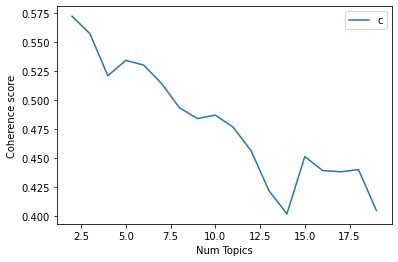

In [50]:
# Hyperparameter Tuning

topics_range = range(2, 20, 1)
model_results = { 'Topics': [],
                 'Coherence': []
                }

for k in topics_range:
    lda_model_test = LdaMulticore(corpus=corpus_tfidf, id2word=dct, num_topics=k, random_state=42, chunksize=100, iterations=25, passes=2, workers=3)
    coherence_model_lda = CoherenceModel(model=lda_model_test, texts=processed_docs, dictionary=dct, coherence='c_v')    
    cv = coherence_model_lda.get_coherence()
    model_results['Topics'].append(k)
    model_results['Coherence'].append(cv)

plt.plot(model_results['Topics'], model_results['Coherence'])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [0]:
model_tfidf_lda = LdaMulticore(corpus_tfidf,num_topics=3,random_state=42, id2word=dct, chunksize=100, iterations=25, passes=2, workers=3)

In [52]:
pip install pyldavis

     |████████████████████████████████| 1.6MB 4.9MB/s 
     |████████████████████████████████| 552kB 39.0MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=ced7bebec5677cd151ab16cb82a7954d00a7eef133e4c907a952267cff50bd78
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=0b8480e273fdfa3701ff4b4eb11556d33f1ca33e97e8c9046f87f7b2305403c8
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyldavis funcy


In [53]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_tfidf_lda, corpus_tfidf, dct)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.327384 -0.073224       1        1  36.266163
1      0.231785 -0.227430       2        1  32.805740
0      0.095599  0.300654       3        1  30.928097, topic_info=        Term        Freq       Total Category  logprob  loglift
151       là  665.000000  665.000000  Default  30.0000  30.0000
154     quoi  665.000000  665.000000  Default  29.0000  29.0000
149  bouahah  632.000000  632.000000  Default  28.0000  28.0000
150    envoi  632.000000  632.000000  Default  27.0000  27.0000
155   regard  632.000000  632.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
134    manqu  135.953537  220.157349   Topic3  -4.5482   0.6915
5       http  163.173141  724.632812   Topic3  -4.3657  -0.3173
72   restaur  126.274620  182.963974   Topic3  -4.6221   0.8027
69      autr  124.391495  165.556870   Topic3  -4.6371   0.8876
71      ouvr  124.557899  176.829849   Topic3  -4.6358   0.8231

[148 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
222       2  0.992158   abrut
186       3  0.995827  accord
168       1  0.995624      ah
137       2  0.994867   allez
298       3  0.992894    alor
...     ...       ...     ...
197       1  0.997899    vois
52        2  0.630192      ça
52        3  0.369632      ça
68        1  0.998476    élus
166       2  0.993609    être

[142 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [54]:
pprint(model_tfidf_lda.top_topics(bow_corpus)[0:2])

[([(0.017696928, 'esper'),
   (0.015633713, 'va'),
   (0.015258217, 'ça'),
   (0.013633072, 'driv'),
   (0.013227954, 'ger'),
   (0.013227744, 'dar'),
   (0.0126990145, 'giuxliano'),
   (0.012634621, 'relanc'),
   (0.012634621, 'avril'),
   (0.012634621, 'chaîn'),
   (0.012634618, 'repr'),
   (0.012634618, 'pouvoir'),
   (0.012634618, 'cour'),
   (0.012634618, 'tour'),
   (0.0111606, 'mcdo'),
   (0.010845644, 'test'),
   (0.010813539, 'tout'),
   (0.010692065, 'fair'),
   (0.010622864, 'pet'),
   (0.01044201, 'jv')],
  -17.347463224810774),
 ([(0.04417508, 'là'),
   (0.044175077, 'quoi'),
   (0.041956864, 'bouahah'),
   (0.041956823, 'envoi'),
   (0.041956805, 'regard'),
   (0.041956794, 'oblig'),
   (0.041956794, 'mdrrrr'),
   (0.03059228, 'rt'),
   (0.028687565, 'http'),
   (0.014493069, 'tranquill'),
   (0.013001699, 'driv'),
   (0.01276035, 'ah'),
   (0.011706624, 'svp'),
   (0.01154759, 'bos'),
   (0.011516315, 'quand'),
   (0.009777057, 'ouvert'),
   (0.009568668, 'mcdonald'),
  

In [55]:
for idx,topic in model_tfidf_lda.print_topics():
    pprint('Topic {} : Word: {}'.format(idx,topic))

('Topic 0 : Word: 0.024*"pomm" + 0.023*"lucynotluc" + 0.023*"ferm" + '
 '0.022*"ok" + 0.019*"pa" + 0.017*"mcdo" + 0.016*"mdr" + 0.015*"merc" + '
 '0.015*"réouvr" + 0.013*"sais"')
('Topic 1 : Word: 0.018*"esper" + 0.016*"va" + 0.015*"ça" + 0.014*"driv" + '
 '0.013*"ger" + 0.013*"dar" + 0.013*"giuxliano" + 0.013*"chaîn" + '
 '0.013*"relanc" + 0.013*"avril"')
('Topic 2 : Word: 0.044*"là" + 0.044*"quoi" + 0.042*"bouahah" + 0.042*"envoi" '
 '+ 0.042*"regard" + 0.042*"oblig" + 0.042*"mdrrrr" + 0.031*"rt" + '
 '0.029*"http" + 0.014*"tranquill"')


#### Sujets(Topics) :
- Topic 0 : Des questions à propos la disponiblilité
- Topic 1 : Actualités
- Topic 2 : Confinement


## 10. Evaluation de la modèle LDA-TFIDF

In [56]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model_tfidf_lda, texts=processed_docs, dictionary=dct, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5571157367463692


# Test

In [57]:
def format_topics_tweets(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_tweets_keywords = format_topics_tweets(ldamodel=model_tfidf_lda, corpus=corpus_tfidf, texts=df.text.iloc[-10:].tolist())

# Format
df_dominant_topic = df_topic_tweets_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Text
0,0,2.0,0.8305,"là, quoi, bouahah, envoi, regard, oblig, mdrrr...",@McDoFr_Newsroom tu sais que tu me manque ... 🍟🍔🥤
1,1,1.0,0.7560,"esper, va, ça, driv, ger, dar, giuxliano, chaî...",@ALarigaudrieBFM uniquement si @McDoFr_Newsroo...
2,2,1.0,0.7948,"esper, va, ça, driv, ger, dar, giuxliano, chaî...",Jpp du menu filet o fish @McDoFr_Newsroom vous...
3,3,0.0,0.3333,"pomm, lucynotluc, ferm, ok, pa, mcdo, mdr, mer...","@McDoFr_Newsroom Bonjour, à quand la réouvertu..."
4,4,1.0,0.8389,"esper, va, ça, driv, ger, dar, giuxliano, chaî...",RT @TPMP: Très belle opération de @McDoFr_News...
5,5,2.0,0.7514,"là, quoi, bouahah, envoi, regard, oblig, mdrrr...",@lucynotlucie @McDoFr_Newsroom Javvvvv ce taff...
6,6,0.0,0.8378,"pomm, lucynotluc, ferm, ok, pa, mcdo, mdr, mer...",RT @lucynotlucie: 5ème personne qui me demande...
7,7,0.0,0.8344,"pomm, lucynotluc, ferm, ok, pa, mcdo, mdr, mer...",@giuxliano @McDoFr_Newsroom
8,8,0.0,0.8249,"pomm, lucynotluc, ferm, ok, pa, mcdo, mdr, mer...",5ème personne qui me demande si Mcdo c’est fer...
9,9,2.0,0.8397,"là, quoi, bouahah, envoi, regard, oblig, mdrrr...",@McDoFr_Newsroom étant donné la situation les ...


# Interprétation 

 On a trois grands thèmes dominants, deux sont centrés sur l'actualité dans le monde généralement et sur la  france précisément et sur le virus Covid-19, et le troisième c'est les questions des clients à propos la disponibilité .
Tous ces sujets peuvent nous donner une idée sur l'image et la position du macdo france par rapport à ses concurrents  .